In [2]:
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_data(image_dir, mask_dir, image_size=(256, 256)):
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    images = []
    masks = []

    # List all image filenames and sort them
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    for filename in image_filenames:
        img_path = os.path.join(image_dir, filename)
        mask_filename = filename.replace('.jpg', '.png')  # Replace extension for masks
        mask_path = os.path.join(mask_dir, mask_filename)

        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask file not found: {mask_path}")
            continue

        img = load_img(img_path, color_mode='rgb', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        img = img_to_array(img)
        mask = img_to_array(mask)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Correct paths according to your setup
image_dir = r'C:\Users\Arjun\Downloads\archive(3)\Image'
mask_dir = r'C:\Users\Arjun\Downloads\archive(3)\Mask'

# Load the dataset
images, masks = load_data(image_dir, mask_dir)


In [3]:
len(images)

290

In [4]:
len(masks)

290

## Normalizing and Visualizing a sample image & mask

In [7]:
print(np.min(images[0]), np.max(images[0]))

6.0 255.0


In [9]:
print(images[0].shape)

(256, 256, 3)


In [8]:
images[0] = images[0].astype(float)

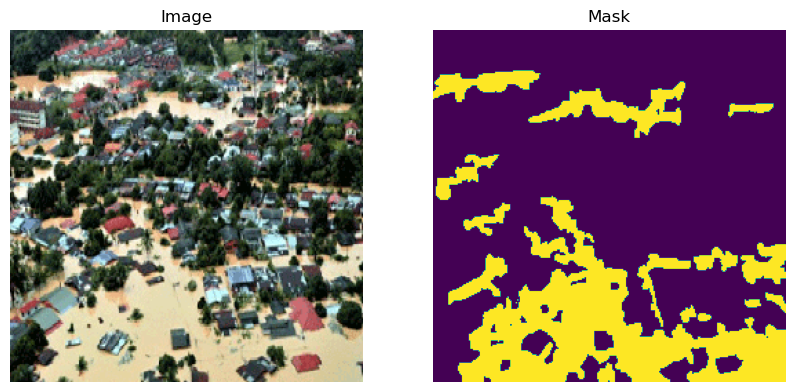

In [10]:
normalized_image = (images[0] - 6.0) / (255.0 - 6.0)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(normalized_image, 0, 1))
plt.axis('off')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(np.clip(masks[0], 0, 1))
plt.axis('off')
plt.title("Mask")

plt.show()

In [11]:

# Normalize images and masks
images = images / 255.0
masks = masks / 255.0

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


## U-Net Implementation

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:
model = unet_model()

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=15)


Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1252s 72s/step - accuracy: 0.5519 - loss: 0.7276 - val_accuracy: 0.7894 - val_loss: 0.6668
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 992s 62s/step - accuracy: 0.7337 - loss: 0.6212 - val_accuracy: 0.6899 - val_loss: 0.5561
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1064s 67s/step - accuracy: 0.6430 - loss: 0.6074 - val_accuracy: 0.7882 - val_loss: 0.5062


## Plotting Model's Loss and Accuracy

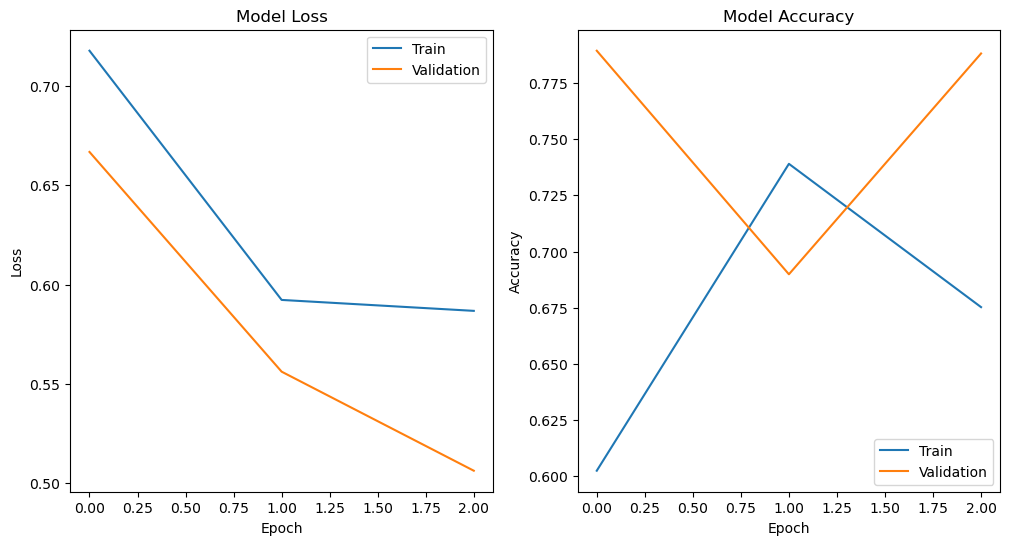

In [15]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [16]:
predictions = model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 16s/step


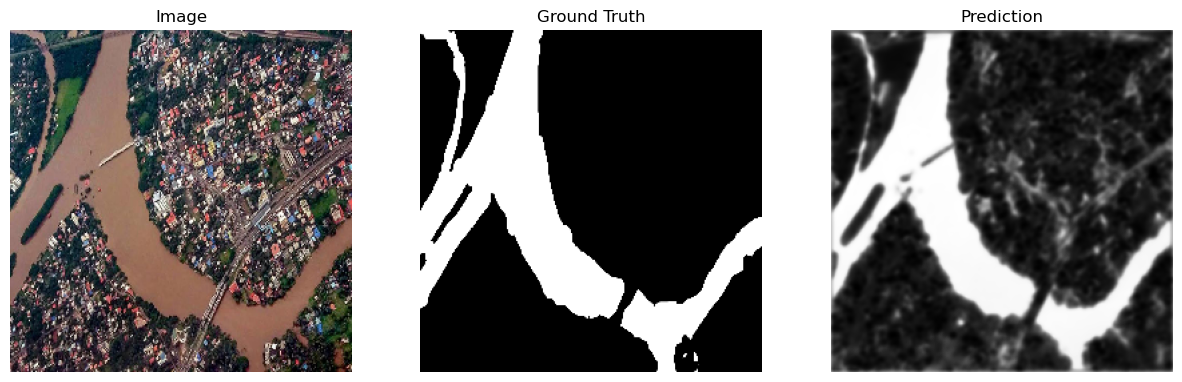

In [20]:
def plot_image_groundtruth_prediction(image, groundtruth, prediction, index):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image[index])
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruth[index].squeeze(),cmap='gray')  
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[index].squeeze(),cmap='gray')  
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

# Sample
plot_image_groundtruth_prediction(X_val, y_val, predictions, index=0)

## Data Augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator 
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen.fit(X_train)


In [22]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=15),
                    validation_data=(X_val, y_val),
                    epochs=3)

Epoch 1/3


C:\Users\Arjun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 858s 54s/step - accuracy: 0.6017 - loss: 0.6691 - val_accuracy: 0.6484 - val_loss: 0.6017
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 951s 60s/step - accuracy: 0.6314 - loss: 0.6438 - val_accuracy: 0.7580 - val_loss: 0.5761
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 977s 64s/step - accuracy: 0.6071 - loss: 0.6540 - val_accuracy: 0.7969 - val_loss: 0.5727


## Predict with Data Augmentation

In [23]:
def predict_with_augmentation(model, datagen, X_val, y_val, index=0):
    # Create a batch generator for the validation data
    augmented_generator = datagen.flow(X_val, batch_size=1, shuffle=False)
    
    # Get augmented image and mask
    augmented_image = next(augmented_generator)[0]
    
    # Make predictions
    predictions = model.predict(np.expand_dims(augmented_image, axis=0))
    
    return augmented_image, y_val[index], predictions[0]

# Example usage
augmented_image, groundtruth, prediction = predict_with_augmentation(model, datagen, X_val, y_val, index=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


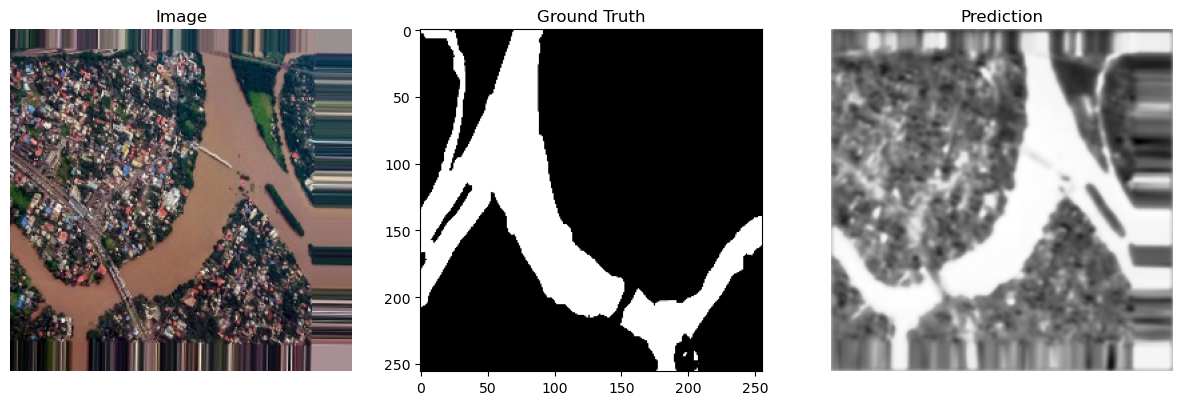

In [24]:
def plot_image_groundtruth_prediction(image, groundtruth, prediction):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruth.squeeze(), cmap='gray')  
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')  
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

# Example usage
plot_image_groundtruth_prediction(augmented_image, groundtruth, prediction)


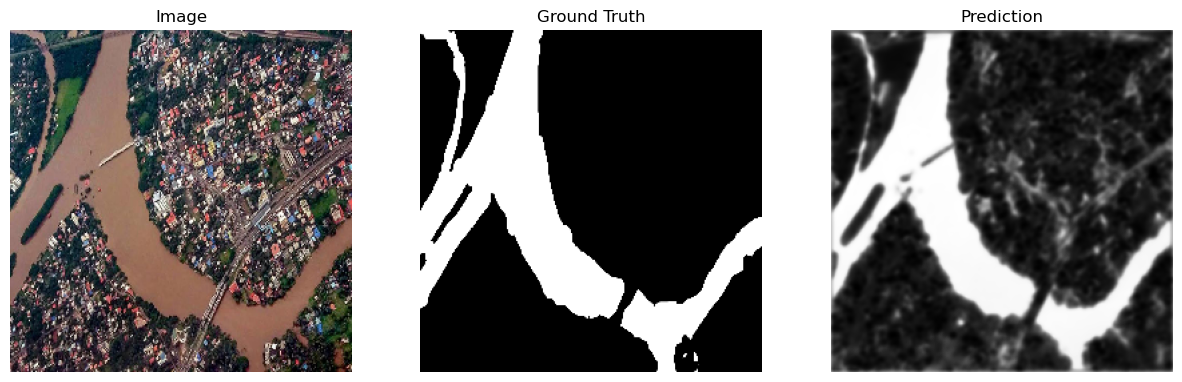

In [30]:
import matplotlib.pyplot as plt

def plot_image_groundtruth_prediction(images, groundtruths, predictions, index):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index])
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruths[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

# Example usage
plot_image_groundtruth_prediction(X_val, y_val, predictions, index=0)
